# Proyecto Final
## Pontificia Universidad Javeriana
### Analitica de Datos
#### Realizado por: Sara Peña y Frank Hernandez

In [2]:
# Instalar librerias
%pip install librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl.metadata (5.6 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl (1.0 MB)
Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl (164 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow_hub


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install soundfile


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import warnings
import glob
from collections import Counter, defaultdict
import seaborn as sns
import random
from scipy import stats
import tensorflow as tf
from scipy.interpolate import interp1d
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from scipy.interpolate import interp1d


In [4]:
# Importar datos
file_path= 'IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1/(02)_dont_kill_the_whale-1.wav'
y, sr = librosa.load(file_path, mono=True, duration=30)

#Calcular tempo
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

# Si tempo es un array, extráelo:
if isinstance(tempo, (list, np.ndarray)):
    tempo = tempo[0]

print(f"Tempo estimado: {tempo:.2f} BPM")

Tempo estimado: 89.10 BPM


In [12]:
#Calcular cromagrama
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
chroma_mean = chroma.mean(axis=1)  # Promedio para simplificar

#Usar perfil de tonalidad
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                          2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                          2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

#Comparar el cromagrama con el perfil de tonalidad
correlation_major = [np.corrcoef(np.roll(major_profile, i), chroma_mean)[0, 1] for i in range(12)]
correlation_minor = [np.corrcoef(np.roll(minor_profile, i), chroma_mean)[0, 1] for i in range(12)]

#Seleccionar la tonalidad con mayor correlación
max_major = np.max(correlation_major)
max_minor = np.max(correlation_minor)

if max_major > max_minor:
    key_index = np.argmax(correlation_major)
    key_type = "Major"
else:
    key_index = np.argmax(correlation_minor)
    key_type = "Minor"

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F',
              'F#', 'G', 'G#', 'A', 'A#', 'B']

detected_key = f"{note_names[key_index]} {key_type}"
print("Tonalidad detectada:", detected_key)




Tonalidad detectada: E Minor


Ejemplo de uso de YAMNet para detectar tonalidades

In [24]:
# 1. Cargar el modelo YAMNet desde TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

waveform, sr = librosa.load(file_path, sr=16000)  # YAMNet requiere 16kHz

# 3. Pasar el audio al modelo
scores, embeddings, spectrogram = yamnet_model(waveform)

# 4. Descargar la lista de clases de AudioSet
import urllib.request
import csv

class_map_path = tf.keras.utils.get_file(
    'yamnet_class_map.csv',
    'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv'
)

# Leer los nombres de las clases
class_names = []
with open(class_map_path) as f:
    reader = csv.DictReader(f)
    for row in reader:
        class_names.append(row['display_name'])

# 5. Obtener las predicciones más probables
# Calcular los puntajes promedios por clase
mean_scores = tf.reduce_mean(scores, axis=0).numpy()

# Obtener los índices de las 5 clases más probables
top5_i = np.argsort(mean_scores)[::-1][:5]

print("🎧 Top 5 predicciones:")
for i in top5_i:
    print(f"{class_names[i]:<30} - Score: {mean_scores[i]:.3f}")


🎧 Top 5 predicciones:
Music                          - Score: 0.946
Swing music                    - Score: 0.037
Country                        - Score: 0.020
Soul music                     - Score: 0.015
Psychedelic rock               - Score: 0.014


Modelo propio entrenado con librerias de TensorFlow para predecir los instrumentos de archivos de audio

✓ Usando directorio: IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1
🎵 Entrenando modelo mejorado con características avanzadas...
📁 Encontrados 807 archivos de audio
📋 Archivos con etiquetas válidas: 399
📊 Distribución de instrumentos:
   Piano: 170
   Voice/Vocals: 139
   Electric Guitar: 109
   Saxophone: 84
   Acoustic Guitar: 79
   Trumpet: 46
   Organ: 36
   Cello: 25
   Violin: 24
   Flute: 1
  Procesando 1/399...
  Procesando 51/399...
  Procesando 101/399...
  Procesando 151/399...
  Procesando 201/399...
  Procesando 251/399...
  Procesando 301/399...
  Procesando 351/399...
✅ Total de segmentos procesados: 1237
📊 Forma de X: (1237, 345, 157, 1)
📊 Instrumentos detectados: ['cel', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
🏋️ Iniciando entrenamiento...
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 309s 5s/step - accuracy: 0.1771 - loss: 2.5864 - precision: 0.2411 - recall: 0.3709 - val_accuracy: 0.3790 - val_loss: 1.3005 - val_precision: 0.0000e+00 - val_reca

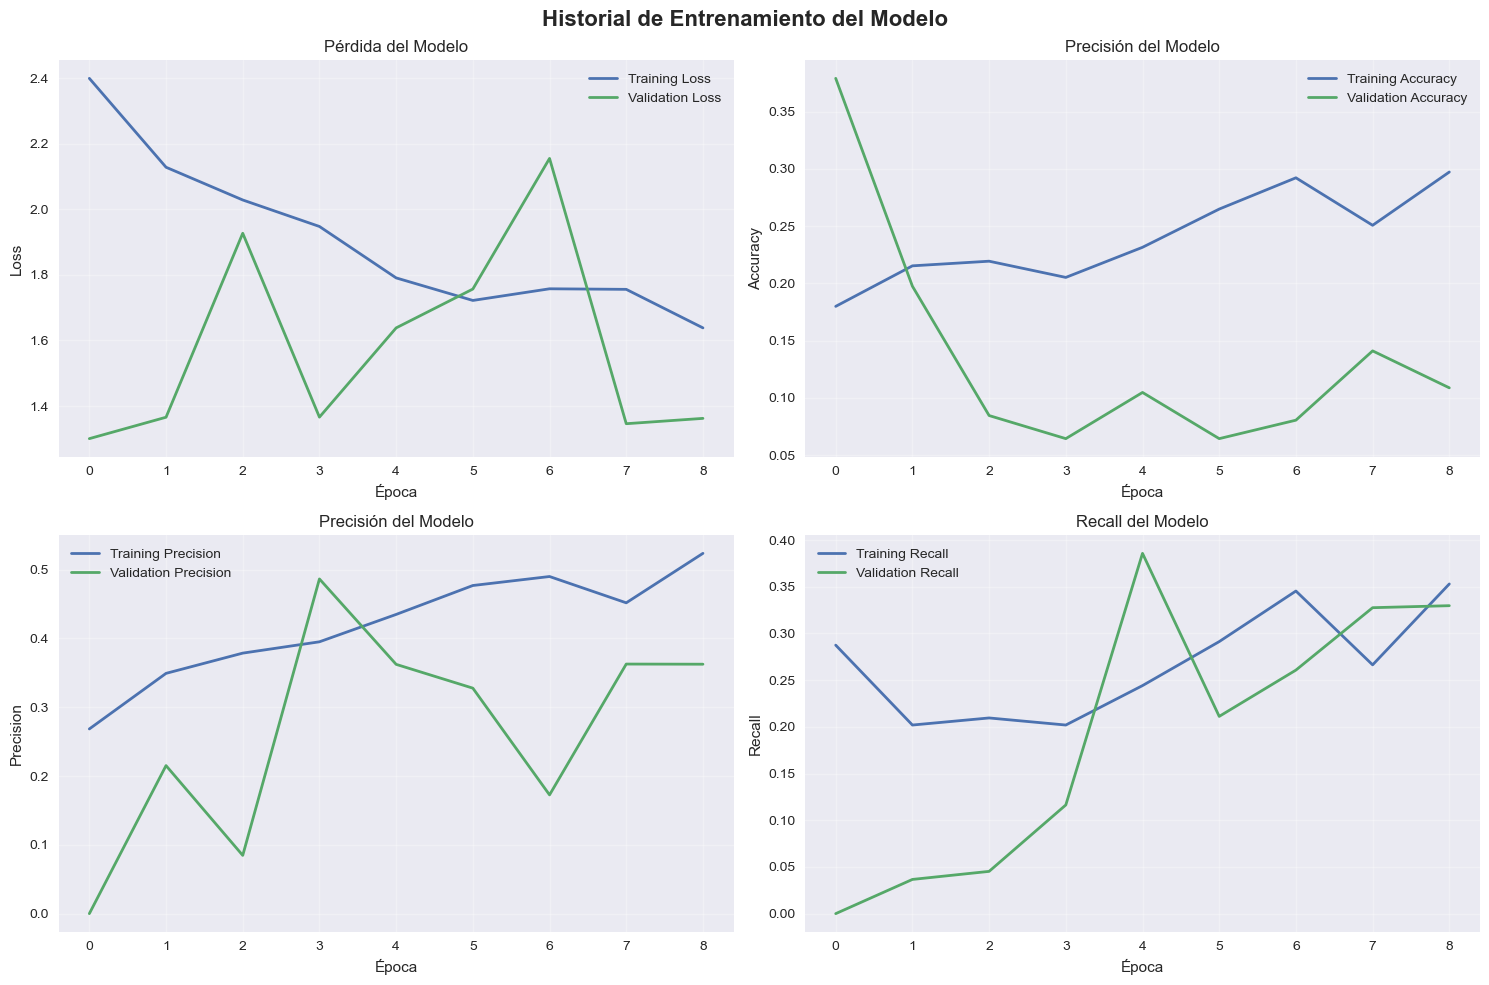

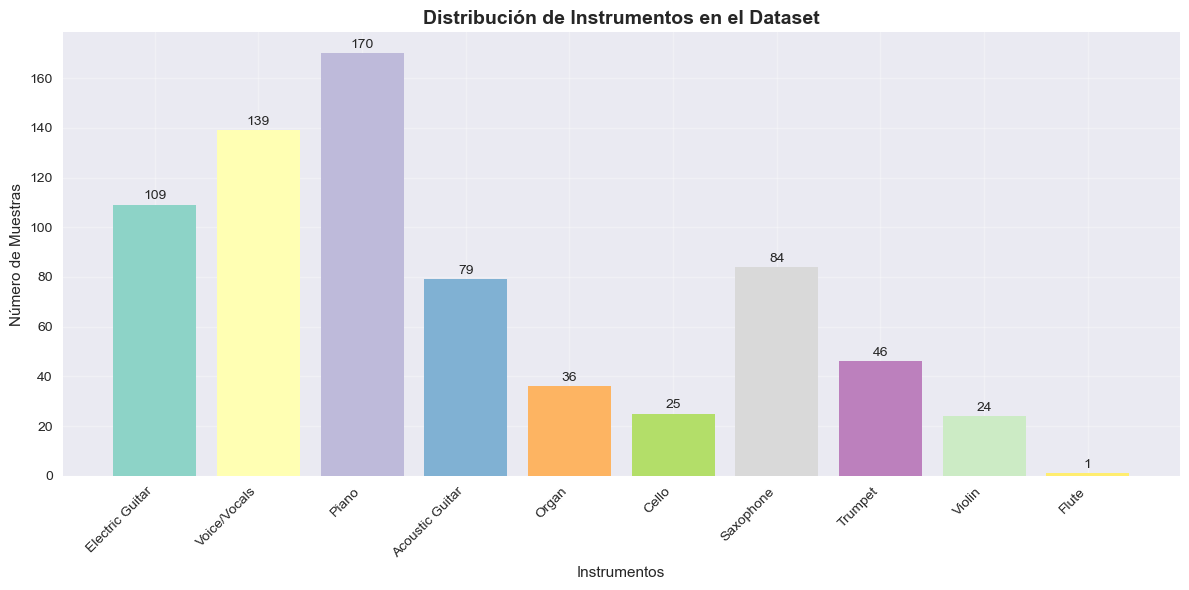

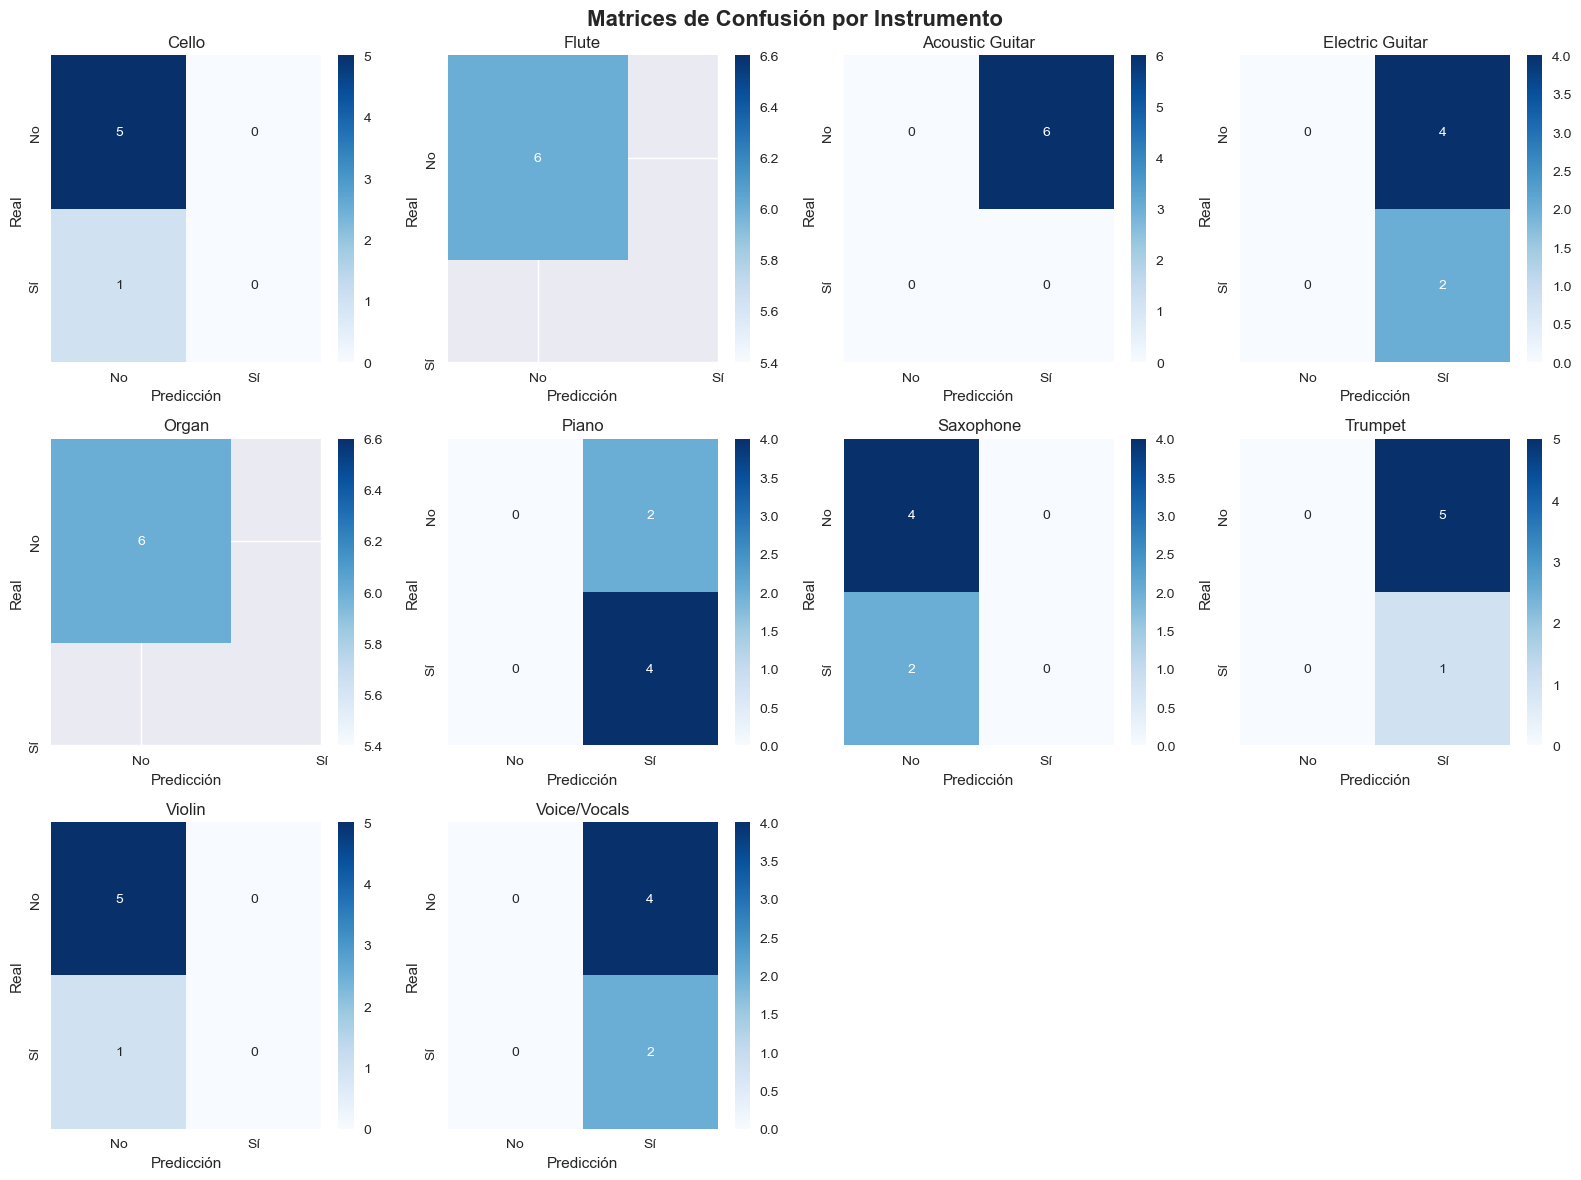

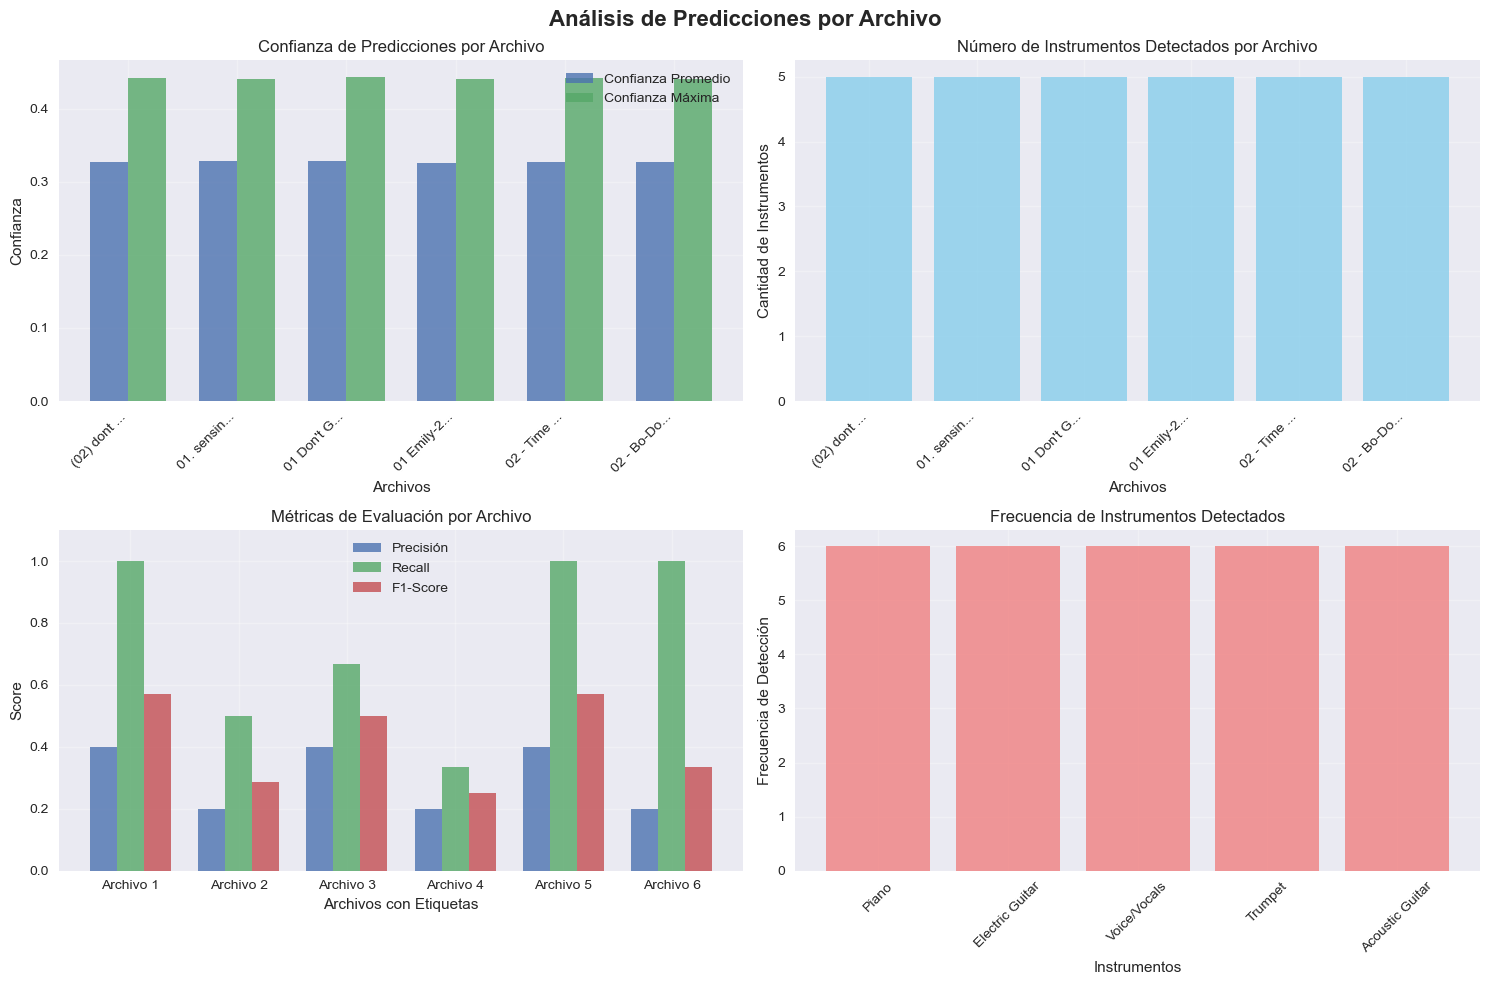

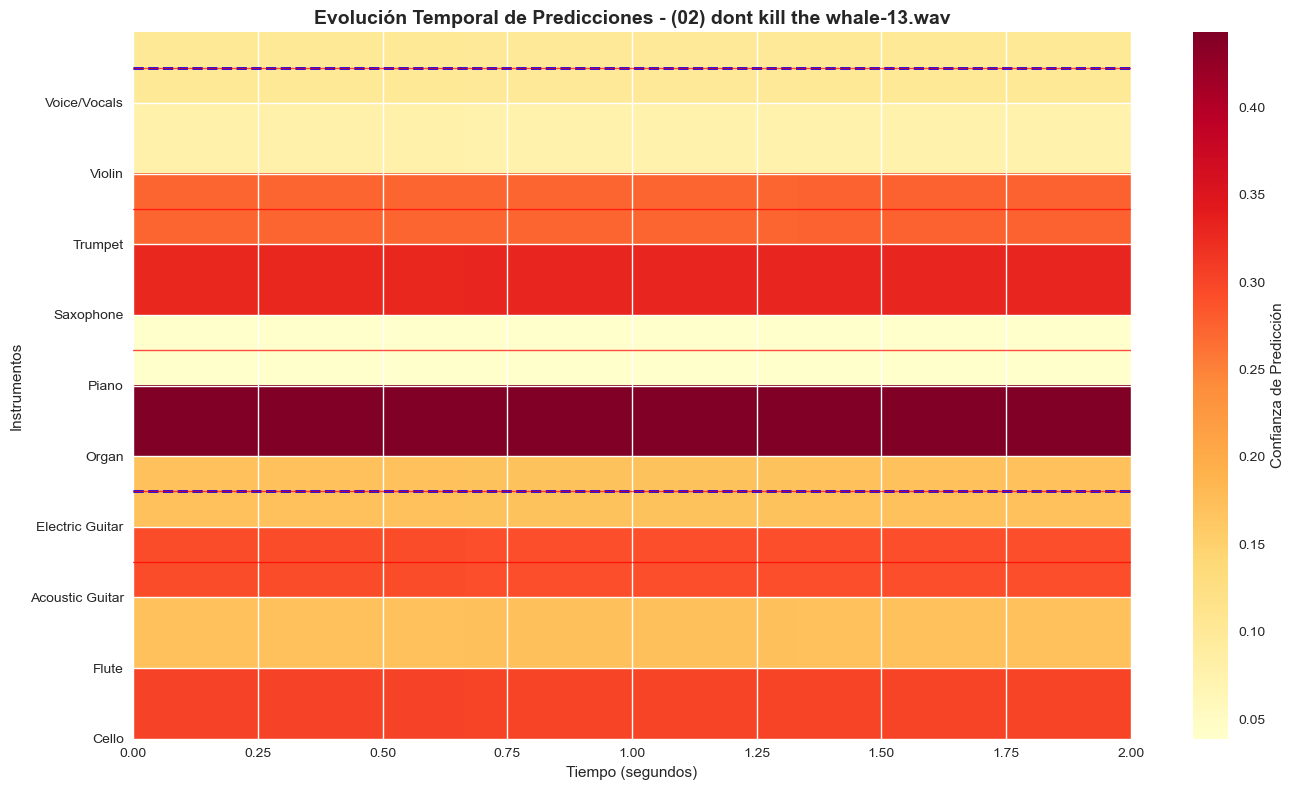

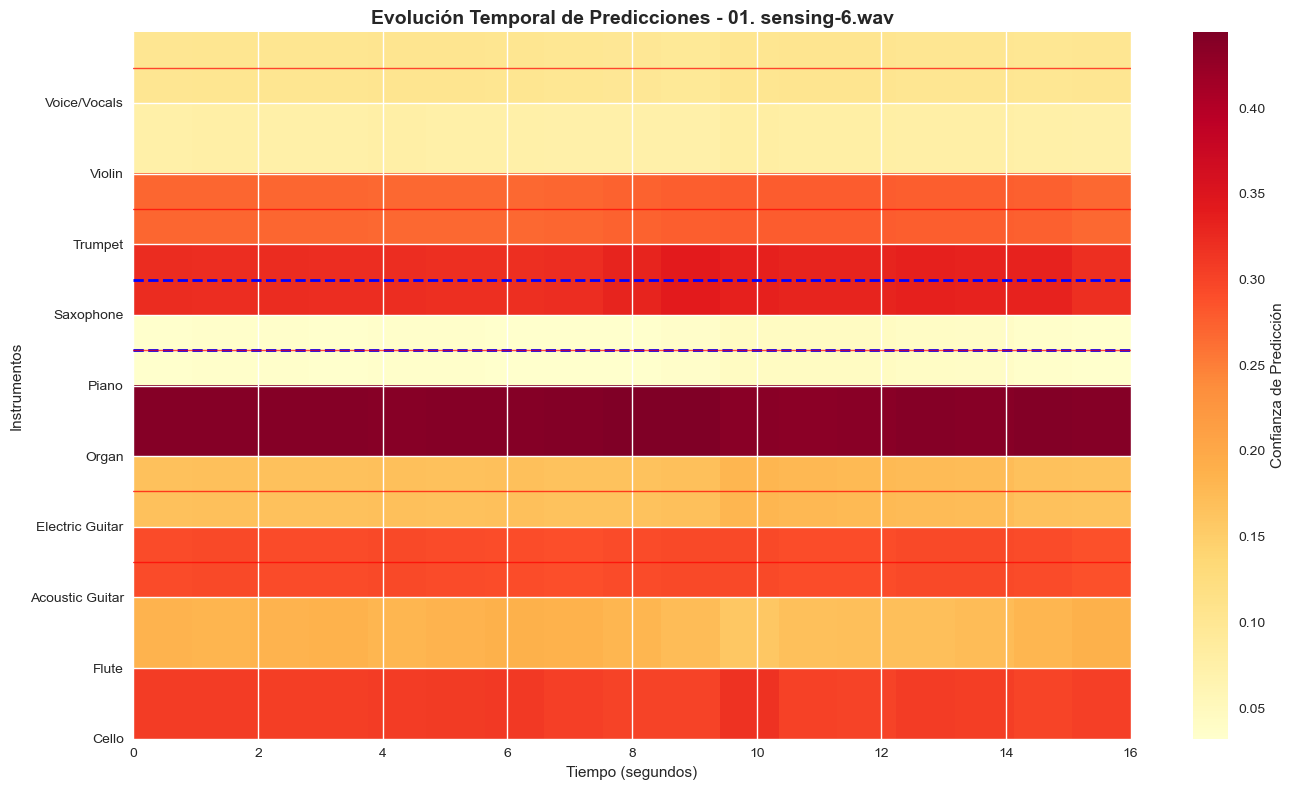

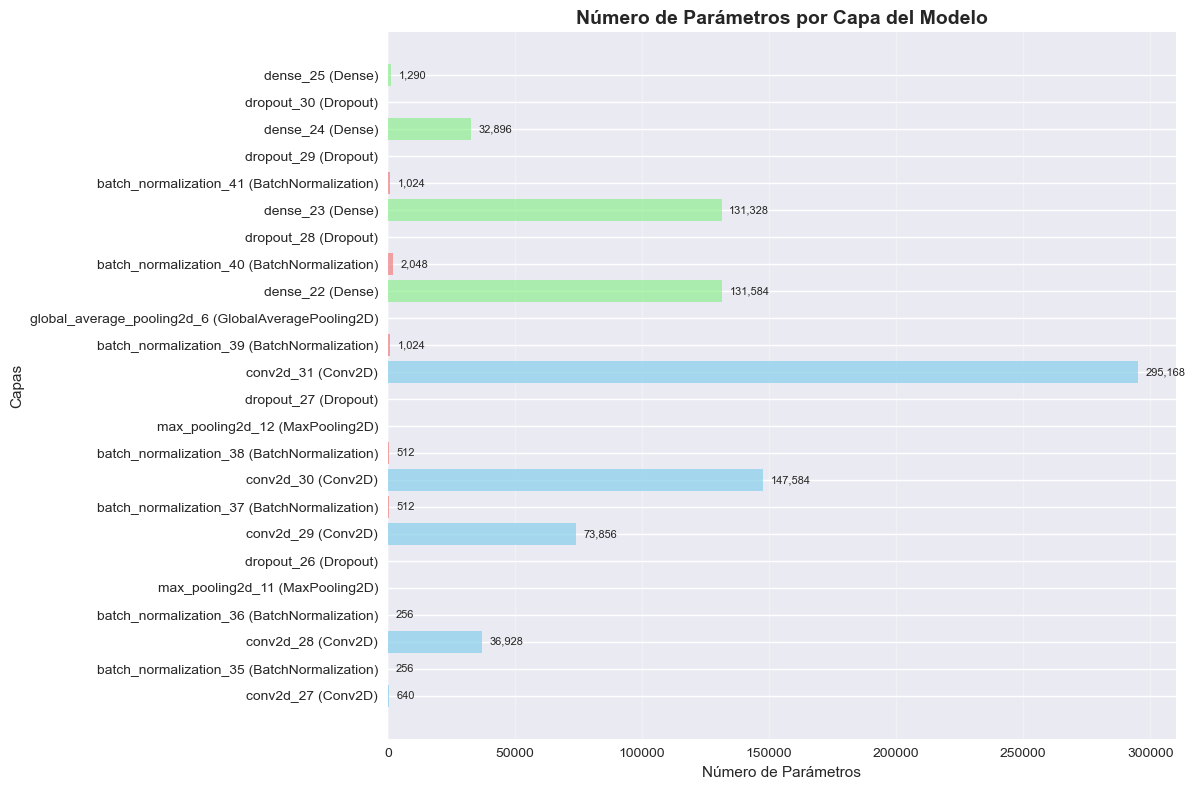

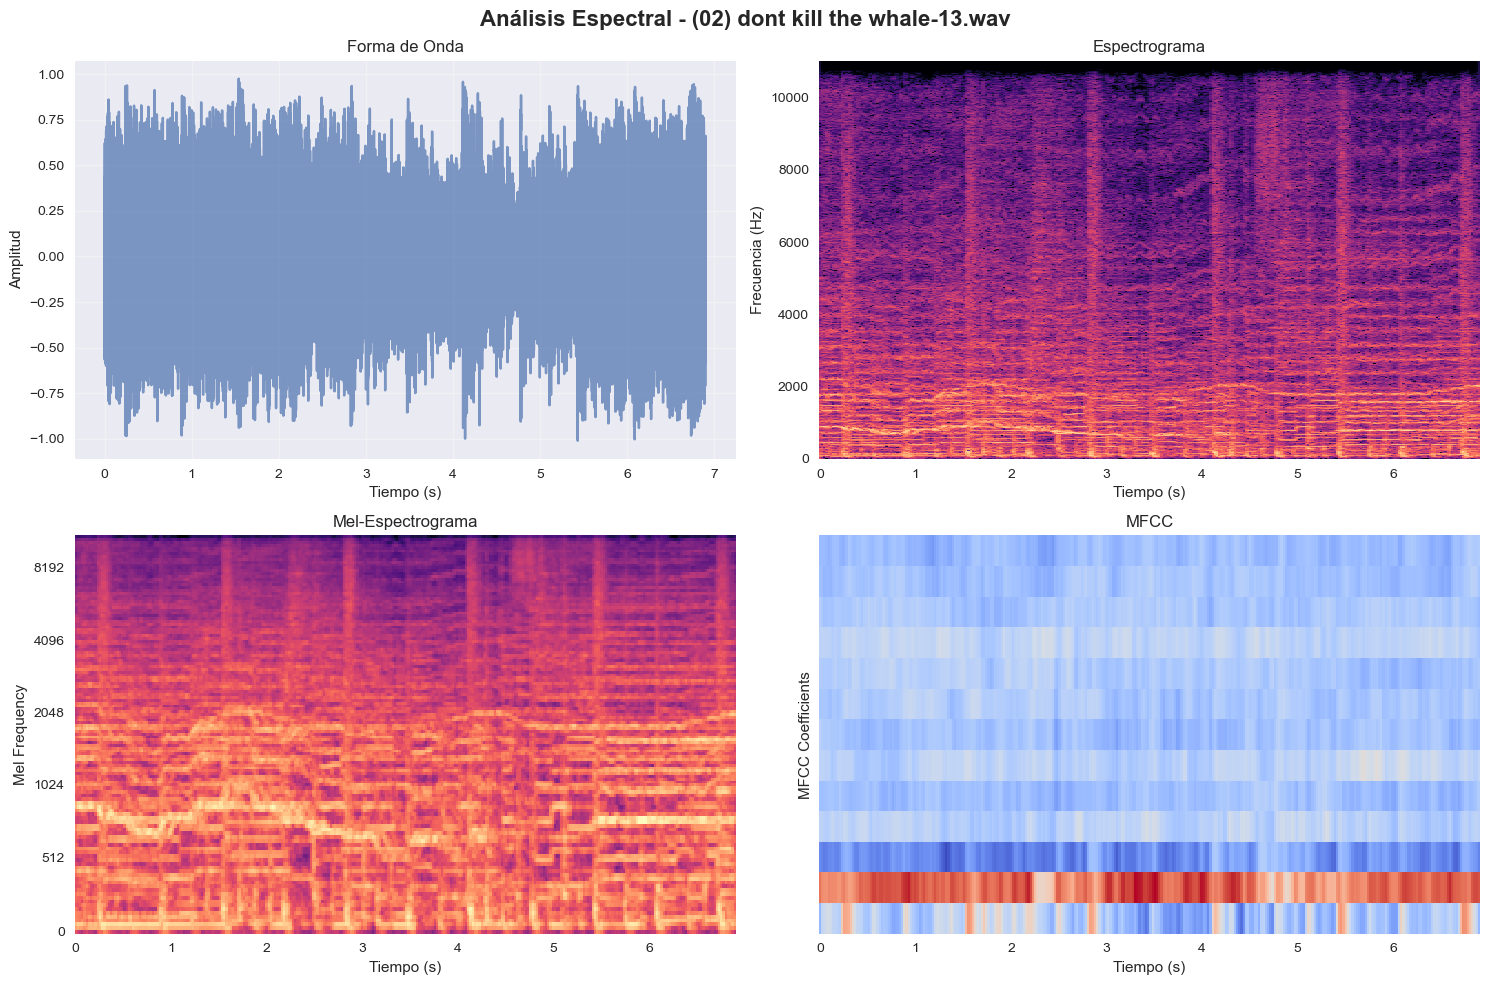


📊 RESUMEN DE MÉTRICAS GLOBALES:


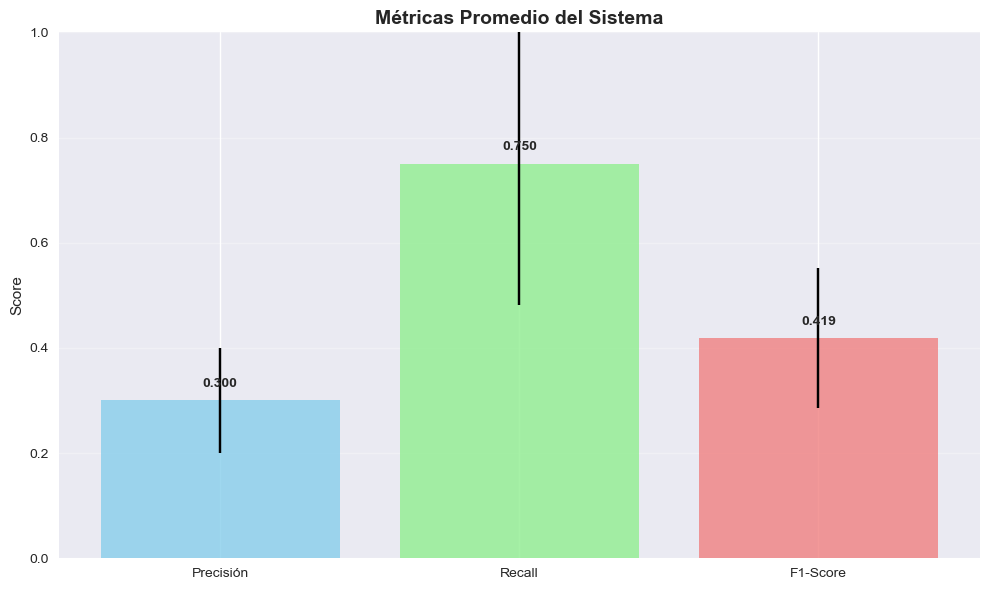

Precisión promedio: 0.300 ± 0.100
Recall promedio: 0.750 ± 0.268
F1-Score promedio: 0.419 ± 0.133

✅ ANÁLISIS COMPLETO FINALIZADO
📊 Se generaron todas las visualizaciones del modelo y predicciones


In [27]:
#Modelo
warnings.filterwarnings('ignore')

# Configurar para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configurar matplotlib para mejor visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Mapeo de códigos IRMAS a nombres completos
INSTRUMENT_NAMES = {
    'cel': 'Cello',
    'cla': 'Clarinet', 
    'flu': 'Flute',
    'gac': 'Acoustic Guitar',
    'gel': 'Electric Guitar',
    'org': 'Organ',
    'pia': 'Piano',
    'sax': 'Saxophone',
    'tru': 'Trumpet',
    'vio': 'Violin',
    'voi': 'Voice/Vocals'
}

def extract_enhanced_features(y_audio, sr=22050):
    """Extrae características mejoradas del audio"""
    features = {}
    
    # 1. Mel-spectrogram mejorado
    mel_spec = librosa.feature.melspectrogram(
        y=y_audio, sr=sr, n_mels=128, hop_length=256, n_fft=2048, 
        fmin=80, fmax=8000
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    features['mel_spec'] = mel_spec_db
    
    # 2. MFCC (coeficientes cepstrales)
    mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13, hop_length=256)
    features['mfcc'] = mfcc
    
    # 3. Características espectrales
    spectral_centroids = librosa.feature.spectral_centroid(y=y_audio, sr=sr, hop_length=256)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y_audio, sr=sr, hop_length=256)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_audio, sr=sr, hop_length=256)[0]
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y_audio, hop_length=256)[0]
    
    # 4. Chroma features
    chroma = librosa.feature.chroma_stft(y=y_audio, sr=sr, hop_length=256)
    features['chroma'] = chroma
    
    # 5. Características temporales
    onset_frames = librosa.onset.onset_detect(y=y_audio, sr=sr, hop_length=256)
    tempo, beats = librosa.beat.beat_track(y=y_audio, sr=sr, hop_length=256)
    
    # Combinar características
    target_frames = mel_spec_db.shape[1]
    
    def resize_feature(feature, target_frames):
        if len(feature.shape) == 1:
            feature = feature.reshape(1, -1)
        if feature.shape[1] != target_frames:
            x_old = np.linspace(0, 1, feature.shape[1])
            x_new = np.linspace(0, 1, target_frames)
            feature_resized = np.zeros((feature.shape[0], target_frames))
            for i in range(feature.shape[0]):
                f = interp1d(x_old, feature[i], kind='linear', fill_value='extrapolate')
                feature_resized[i] = f(x_new)
            return feature_resized
        return feature
    
    # Redimensionar características
    mfcc_resized = resize_feature(mfcc, target_frames)
    chroma_resized = resize_feature(chroma, target_frames)
    spectral_centroids_resized = resize_feature(spectral_centroids.reshape(1, -1), target_frames)
    spectral_rolloff_resized = resize_feature(spectral_rolloff.reshape(1, -1), target_frames)
    spectral_bandwidth_resized = resize_feature(spectral_bandwidth.reshape(1, -1), target_frames)
    zero_crossing_resized = resize_feature(zero_crossing_rate.reshape(1, -1), target_frames)
    
    # Combinar todas las características
    combined_features = np.vstack([
        mel_spec_db,
        mfcc_resized,
        chroma_resized,
        spectral_centroids_resized,
        spectral_rolloff_resized,
        spectral_bandwidth_resized,
        zero_crossing_resized
    ])
    
    return combined_features

def load_and_train_enhanced_model(data_dir, max_files=500):
    """Carga datos y entrena un modelo mejorado con más características"""
    print("🎵 Entrenando modelo mejorado con características avanzadas...")
    
    # Cargar etiquetas
    audio_labels = {}
    wav_files = glob.glob(os.path.join(data_dir, "**/*.wav"), recursive=True)
    
    print(f"📁 Encontrados {len(wav_files)} archivos de audio")
    
    for wav_file in wav_files[:max_files]:
        wav_basename = os.path.splitext(wav_file)[0]
        txt_file = wav_basename + ".txt"
        
        if os.path.exists(txt_file):
            try:
                with open(txt_file, 'r') as f:
                    content = f.read().strip()
                    labels = [label.strip() for label in content.split('\t') if label.strip()]
                    if labels:
                        audio_labels[wav_file] = labels
            except:
                continue
    
    print(f"📋 Archivos con etiquetas válidas: {len(audio_labels)}")
    
    # Balancear dataset
    label_counts = Counter()
    for labels in audio_labels.values():
        for label in labels:
            label_counts[label] += 1
    
    print("📊 Distribución de instrumentos:")
    for instrument, count in label_counts.most_common():
        name = INSTRUMENT_NAMES.get(instrument, instrument)
        print(f"   {name}: {count}")
    
    # Procesar audio con data augmentation
    X, y = [], []
    for i, (file_path, labels) in enumerate(list(audio_labels.items())[:max_files]):
        if i % 50 == 0:
            print(f"  Procesando {i+1}/{min(len(audio_labels), max_files)}...")
        
        try:
            y_audio, sr = librosa.load(file_path, sr=22050)
            
            segment_len = 22050 * 4
            hop_len = 22050 * 2
            
            segments_processed = 0
            for start in range(0, len(y_audio) - segment_len + 1, hop_len):
                if segments_processed >= 3:
                    break
                    
                end = start + segment_len
                y_segment = y_audio[start:end]
                
                augmentation_factor = 1
                for label in labels:
                    if label_counts[label] < 50:
                        augmentation_factor = 2
                        break
                
                for aug in range(augmentation_factor):
                    segment_to_process = y_segment.copy()
                    
                    if aug > 0:
                        noise_factor = 0.005
                        noise = np.random.normal(0, noise_factor, len(segment_to_process))
                        segment_to_process += noise
                        
                        if random.random() > 0.5:
                            n_steps = random.uniform(-1, 1)
                            segment_to_process = librosa.effects.pitch_shift(
                                segment_to_process, sr=sr, n_steps=n_steps
                            )
                    
                    features = extract_enhanced_features(segment_to_process, sr)
                    
                    for i in range(features.shape[0]):
                        feature_row = features[i]
                        features[i] = (feature_row - np.mean(feature_row)) / (np.std(feature_row) + 1e-8)
                    
                    X.append(features)
                    y.append(labels)
                    segments_processed += 1
                    
        except Exception as e:
            print(f"Error procesando {file_path}: {e}")
            continue
    
    if len(X) == 0:
        raise ValueError("No se pudieron procesar archivos de audio")
    
    print(f"✅ Total de segmentos procesados: {len(X)}")
    
    # Preparar datos
    X = np.array(X)
    X = X.transpose(0, 2, 1)
    X = X[..., np.newaxis]
    
    mlb = MultiLabelBinarizer()
    y_bin = mlb.fit_transform(y)
    
    print(f"📊 Forma de X: {X.shape}")
    print(f"📊 Instrumentos detectados: {list(mlb.classes_)}")
    
    # Calcular pesos de clase
    class_weights = {}
    for i, class_name in enumerate(mlb.classes_):
        positive_samples = np.sum(y_bin[:, i])
        total_samples = len(y_bin)
        class_weights[i] = total_samples / (2 * positive_samples) if positive_samples > 0 else 1.0
    
    # Modelo más sofisticado
    model = models.Sequential([
        layers.Input(shape=X.shape[1:]),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        
        layers.Dense(y_bin.shape[1], activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=['accuracy', 'precision', 'recall']
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss', patience=8, restore_best_weights=True
    )
    
    # División estratificada
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
    )
    
    print("🏋️ Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train, 
        epochs=25,
        batch_size=16,
        validation_data=(X_val, y_val), 
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("✅ Modelo entrenado exitosamente")
    return model, mlb, history, (X_train, X_val, y_train, y_val), label_counts

def analyze_with_ensemble_prediction(file_path, model, mlb, segment_duration=4, overlap=0.75):
    """Análisis mejorado con predicción por ensemble y umbrales adaptativos"""
    
    print(f"\n🎼 ANÁLISIS DETALLADO DE: {os.path.basename(file_path)}")
    print("=" * 80)
    
    if not os.path.exists(file_path):
        print(f"❌ El archivo no existe: {file_path}")
        return None
    
    # Cargar etiquetas reales
    txt_file = os.path.splitext(file_path)[0] + ".txt"
    real_labels = []
    if os.path.exists(txt_file):
        try:
            with open(txt_file, 'r') as f:
                content = f.read().strip()
                real_labels = [label.strip() for label in content.split('\t') if label.strip()]
        except:
            pass
    
    try:
        y_audio, sr = librosa.load(file_path, sr=22050)
        total_duration = len(y_audio) / sr
        
        print(f"📊 Información del archivo:")
        print(f"   Duración total: {total_duration:.1f} segundos")
        print(f"   Sample rate: {sr} Hz")
        print(f"   Etiquetas reales: {[INSTRUMENT_NAMES.get(label, label) for label in real_labels]}")
        
        segment_len = int(sr * segment_duration)
        hop_len = int(segment_len * (1 - overlap))
        
        all_predictions = []
        segment_confidences = []
        segment_times = []
        
        print(f"\n🔍 Analizando por segmentos...")
        
        for start in range(0, len(y_audio) - segment_len + 1, hop_len):
            end = start + segment_len
            segment = y_audio[start:end]
            segment_time = start / sr
            
            features = extract_enhanced_features(segment, sr)
            
            for i in range(features.shape[0]):
                feature_row = features[i]
                features[i] = (feature_row - np.mean(feature_row)) / (np.std(feature_row) + 1e-8)
            
            features_input = features.transpose(1, 0)[np.newaxis, ..., np.newaxis]
            
            pred = model.predict(features_input, verbose=0)[0]
            all_predictions.append(pred)
            segment_times.append(segment_time)
            
            max_conf = np.max(pred)
            segment_confidences.append(max_conf)
        
        all_predictions = np.array(all_predictions)
        segment_confidences = np.array(segment_confidences)
        segment_times = np.array(segment_times)
        
        print(f"   Total de segmentos analizados: {len(all_predictions)}")
        
        # Filtrar segmentos con baja confianza
        confidence_threshold = np.percentile(segment_confidences, 30)
        high_conf_predictions = all_predictions[segment_confidences >= confidence_threshold]
        
        if len(high_conf_predictions) == 0:
            high_conf_predictions = all_predictions
        
        # Estadísticas mejoradas
        avg_predictions = np.mean(high_conf_predictions, axis=0)
        max_predictions = np.max(high_conf_predictions, axis=0)
        std_predictions = np.std(high_conf_predictions, axis=0)
        median_predictions = np.median(high_conf_predictions, axis=0)
        
        print(f"\n📈 PREDICCIONES RAW POR INSTRUMENTO:")
        print("-" * 60)
        
        for i, instrument in enumerate(mlb.classes_):
            instrument_name = INSTRUMENT_NAMES.get(instrument, instrument.upper())
            print(f"{instrument_name:<18}: Max={max_predictions[i]:.4f} | "
                  f"Avg={avg_predictions[i]:.4f} | Med={median_predictions[i]:.4f} | "
                  f"Std={std_predictions[i]:.4f}")
        
        # Detección inteligente
        print(f"\n🎼 INSTRUMENTOS DETECTADOS (ANÁLISIS INTELIGENTE):")
        print("-" * 60)
        
        detected_instruments = []
        
        for i, instrument in enumerate(mlb.classes_):
            max_conf = max_predictions[i]
            avg_conf = avg_predictions[i]
            med_conf = median_predictions[i]
            std_conf = std_predictions[i]
            
            criteria_1 = max_conf > 0.3
            criteria_2 = avg_conf > 0.15 and std_conf < 0.3
            criteria_3 = med_conf > 0.2
            above_threshold = np.sum(high_conf_predictions[:, i] > 0.2)
            criteria_4 = above_threshold > len(high_conf_predictions) * 0.3
            
            confidence_score = (max_conf * 0.4 + avg_conf * 0.3 + med_conf * 0.3)
            
            if (criteria_1 and criteria_2) or (criteria_1 and criteria_3) or (criteria_2 and criteria_4):
                instrument_name = INSTRUMENT_NAMES.get(instrument, instrument.upper())
                
                if confidence_score > 0.5:
                    confidence_level = "ALTA"
                elif confidence_score > 0.3:
                    confidence_level = "MEDIA"
                else:
                    confidence_level = "BAJA"
                
                detected_instruments.append({
                    'instrument': instrument,
                    'name': instrument_name,
                    'confidence': confidence_score,
                    'max_confidence': max_conf,
                    'avg_confidence': avg_conf,
                    'level': confidence_level,
                    'consistency': 1 - (std_conf / (avg_conf + 1e-8))
                })
        
        detected_instruments.sort(key=lambda x: x['confidence'], reverse=True)
        
        if detected_instruments:
            for i, inst in enumerate(detected_instruments, 1):
                print(f"{i:2d}. {inst['name']:<18} | Confianza: {inst['confidence']:.4f} "
                      f"({inst['level']}) | Consistencia: {inst['consistency']:.3f}")
        else:
            print("   ⚠️  No se detectaron instrumentos con criterios estrictos")
            print("   📝 Top 3 predicciones por confianza máxima:")
            top_indices = np.argsort(max_predictions)[-3:][::-1]
            for idx in top_indices:
                instrument_name = INSTRUMENT_NAMES.get(mlb.classes_[idx], mlb.classes_[idx])
                print(f"      {instrument_name}: {max_predictions[idx]:.4f}")
        
        # Evaluación de precisión
        if real_labels:
            print(f"\n📋 EVALUACIÓN:")
            print("-" * 50)
            detected_codes = [inst['instrument'] for inst in detected_instruments]
            correct = set(real_labels) & set(detected_codes)
            missed = set(real_labels) - set(detected_codes)
            false_positive = set(detected_codes) - set(real_labels)
            
            print(f"✅ Correctos: {[INSTRUMENT_NAMES.get(c, c) for c in correct] if correct else 'Ninguno'}")
            print(f"❌ No detectados: {[INSTRUMENT_NAMES.get(m, m) for m in missed] if missed else 'Ninguno'}")
            print(f"⚠️  Falsos positivos: {[INSTRUMENT_NAMES.get(f, f) for f in false_positive] if false_positive else 'Ninguno'}")
            
            if real_labels:
                precision = len(correct) / len(detected_codes) if detected_codes else 0
                recall = len(correct) / len(real_labels) if real_labels else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                print(f"🎯 Precisión: {precision:.1%}")
                print(f"🎯 Recall: {recall:.1%}")
                print(f"🎯 F1-Score: {f1:.1%}")
        
        return {
            'file_path': file_path,
            'real_labels': real_labels,
            'detected_instruments': detected_instruments,
            'all_predictions': all_predictions,
            'max_predictions': max_predictions,
            'avg_predictions': avg_predictions,
            'segment_times': segment_times,
            'segment_confidences': segment_confidences,
            'audio_data': y_audio,
            'sample_rate': sr
        }
        
    except Exception as e:
        print(f"❌ Error analizando el archivo: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_visualizations(model, history, results, mlb, label_counts, training_data):
    """Crear visualizaciones completas del modelo y resultados"""
    
    print("\n📊 GENERANDO VISUALIZACIONES...")
    print("=" * 60)
    
    X_train, X_val, y_train, y_val = training_data
    
    # 1. Historial de entrenamiento
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Historial de Entrenamiento del Modelo', fontsize=16, fontweight='bold')
    
    # Loss
    axes[0,0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0,0].set_title('Pérdida del Modelo')
    axes[0,0].set_xlabel('Época')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0,1].set_title('Precisión del Modelo')
    axes[0,1].set_xlabel('Época')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Precision
    if 'precision' in history.history:
        axes[1,0].plot(history.history['precision'], label='Training Precision', linewidth=2)
        axes[1,0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1,0].set_title('Precisión del Modelo')
        axes[1,0].set_xlabel('Época')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Recall
    if 'recall' in history.history:
        axes[1,1].plot(history.history['recall'], label='Training Recall', linewidth=2)
        axes[1,1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1,1].set_title('Recall del Modelo')
        axes[1,1].set_xlabel('Época')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Distribución de instrumentos en el dataset
    plt.figure(figsize=(12, 6))
    instruments = [INSTRUMENT_NAMES.get(inst, inst) for inst in label_counts.keys()]
    counts = list(label_counts.values())
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(instruments)))
    bars = plt.bar(instruments, counts, color=colors)
    plt.title('Distribución de Instrumentos en el Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Instrumentos')
    plt.ylabel('Número de Muestras')
    plt.xticks(rotation=45, ha='right')
    
    # Añadir valores en las barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Matriz de confusión promedio
    if results:
        y_true_all = []
        y_pred_all = []
        
        for result in results:
            if result['real_labels']:
                # Crear vector binario para etiquetas reales
                true_binary = np.zeros(len(mlb.classes_))
                for label in result['real_labels']:
                    if label in mlb.classes_:
                        idx = list(mlb.classes_).index(label)
                        true_binary[idx] = 1
                
                # Crear vector binario para predicciones
                pred_binary = np.zeros(len(mlb.classes_))
                for inst in result['detected_instruments']:
                    if inst['instrument'] in mlb.classes_:
                        idx = list(mlb.classes_).index(inst['instrument'])
                        pred_binary[idx] = 1
                
                y_true_all.append(true_binary)
                y_pred_all.append(pred_binary)
        
        if y_true_all:
            y_true_all = np.array(y_true_all)
            y_pred_all = np.array(y_pred_all)
            
            # Matriz de confusión para cada instrumento
            fig, axes = plt.subplots(3, 4, figsize=(16, 12))
            fig.suptitle('Matrices de Confusión por Instrumento', fontsize=16, fontweight='bold')
            
            for i, instrument in enumerate(mlb.classes_):
                if i < 12:  # Máximo 12 instrumentos
                    row = i // 4
                    col = i % 4
                    
                    cm = confusion_matrix(y_true_all[:, i], y_pred_all[:, i])
                    
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                              xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'],
                              ax=axes[row, col])
                    
                    instrument_name = INSTRUMENT_NAMES.get(instrument, instrument)
                    axes[row, col].set_title(f'{instrument_name}')
                    axes[row, col].set_xlabel('Predicción')
                    axes[row, col].set_ylabel('Real')
            
            # Ocultar subplots vacíos
            for i in range(len(mlb.classes_), 12):
                row = i // 4
                col = i % 4
                axes[row, col].set_visible(False)
            
            plt.tight_layout()
            plt.show()
    
    # 4. Análisis de predicciones por archivo
    if results:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Análisis de Predicciones por Archivo', fontsize=16, fontweight='bold')
        
        # Confianza promedio por archivo
        file_names = [os.path.basename(r['file_path']) for r in results]
        avg_confidences = []
        max_confidences = []
        
        for result in results:
            if result['detected_instruments']:
                avg_conf = np.mean([inst['confidence'] for inst in result['detected_instruments']])
                max_conf = np.max([inst['confidence'] for inst in result['detected_instruments']])
            else:
                avg_conf = 0
                max_conf = 0
            avg_confidences.append(avg_conf)
            max_confidences.append(max_conf)
        
        # Gráfico de barras de confianza
        x_pos = np.arange(len(file_names))
        width = 0.35
        
        axes[0,0].bar(x_pos - width/2, avg_confidences, width, label='Confianza Promedio', alpha=0.8)
        axes[0,0].bar(x_pos + width/2, max_confidences, width, label='Confianza Máxima', alpha=0.8)
        axes[0,0].set_title('Confianza de Predicciones por Archivo')
        axes[0,0].set_xlabel('Archivos')
        axes[0,0].set_ylabel('Confianza')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels([name[:10] + '...' if len(name) > 10 else name for name in file_names], 
                                 rotation=45, ha='right')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Número de instrumentos detectados por archivo
        num_instruments = [len(result['detected_instruments']) for result in results]
        axes[0,1].bar(range(len(file_names)), num_instruments, color='skyblue', alpha=0.8)
        axes[0,1].set_title('Número de Instrumentos Detectados por Archivo')
        axes[0,1].set_xlabel('Archivos')
        axes[0,1].set_ylabel('Cantidad de Instrumentos')
        axes[0,1].set_xticks(range(len(file_names)))
        axes[0,1].set_xticklabels([name[:10] + '...' if len(name) > 10 else name for name in file_names], 
                                 rotation=45, ha='right')
        axes[0,1].grid(True, alpha=0.3)
        
        # Métricas de evaluación por archivo
        precisions = []
        recalls = []
        f1_scores = []
        
        for result in results:
            if result['real_labels']:
                detected_codes = [inst['instrument'] for inst in result['detected_instruments']]
                correct = len(set(result['real_labels']) & set(detected_codes))
                
                precision = correct / len(detected_codes) if detected_codes else 0
                recall = correct / len(result['real_labels']) if result['real_labels'] else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
        
        if precisions:
            x_pos = np.arange(len(precisions))
            width = 0.25
            
            axes[1,0].bar(x_pos - width, precisions, width, label='Precisión', alpha=0.8)
            axes[1,0].bar(x_pos, recalls, width, label='Recall', alpha=0.8)
            axes[1,0].bar(x_pos + width, f1_scores, width, label='F1-Score', alpha=0.8)
            axes[1,0].set_title('Métricas de Evaluación por Archivo')
            axes[1,0].set_xlabel('Archivos con Etiquetas')
            axes[1,0].set_ylabel('Score')
            axes[1,0].set_xticks(x_pos)
            axes[1,0].set_xticklabels([f'Archivo {i+1}' for i in range(len(precisions))])
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)
            axes[1,0].set_ylim(0, 1.1)
        
        # Distribución de instrumentos detectados
        all_detected = []
        for result in results:
            for inst in result['detected_instruments']:
                all_detected.append(inst['name'])
        
        if all_detected:
            detected_counts = Counter(all_detected)
            instruments_detected = list(detected_counts.keys())
            counts_detected = list(detected_counts.values())
            
            axes[1,1].bar(instruments_detected, counts_detected, color='lightcoral', alpha=0.8)
            axes[1,1].set_title('Frecuencia de Instrumentos Detectados')
            axes[1,1].set_xlabel('Instrumentos')
            axes[1,1].set_ylabel('Frecuencia de Detección')
            axes[1,1].tick_params(axis='x', rotation=45)
            axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 5. Evolución temporal de predicciones para un archivo específico
    if results:
        for i, result in enumerate(results[:2]):  # Solo los primeros 2 archivos
            if 'segment_times' in result and len(result['all_predictions']) > 0:
                plt.figure(figsize=(14, 8))
                
                # Crear heatmap de predicciones a lo largo del tiempo
                predictions_matrix = result['all_predictions'].T
                segment_times = result['segment_times']
                
                im = plt.imshow(predictions_matrix, aspect='auto', cmap='YlOrRd', 
                              extent=[segment_times[0], segment_times[-1], 0, len(mlb.classes_)])
                
                plt.colorbar(im, label='Confianza de Predicción')
                plt.title(f'Evolución Temporal de Predicciones - {os.path.basename(result["file_path"])}', 
                         fontsize=14, fontweight='bold')
                plt.xlabel('Tiempo (segundos)')
                plt.ylabel('Instrumentos')
                
                # Etiquetas del eje Y
                instrument_names = [INSTRUMENT_NAMES.get(inst, inst) for inst in mlb.classes_]
                plt.yticks(range(len(instrument_names)), instrument_names)
                
                # Marcar instrumentos reales si existen
                if result['real_labels']:
                    for label in result['real_labels']:
                        if label in mlb.classes_:
                            idx = list(mlb.classes_).index(label)
                            plt.axhline(y=idx+0.5, color='blue', linestyle='--', linewidth=2, 
                                      label=f'Real: {INSTRUMENT_NAMES.get(label, label)}')
                
                # Marcar instrumentos detectados
                for inst in result['detected_instruments']:
                    if inst['instrument'] in mlb.classes_:
                        idx = list(mlb.classes_).index(inst['instrument'])
                        plt.axhline(y=idx+0.5, color='red', linestyle='-', linewidth=1, alpha=0.7,
                                  label=f'Detectado: {inst["name"]}')
                
                plt.tight_layout()
                plt.show()
    
    # 6. Arquitectura del modelo
    plt.figure(figsize=(12, 8))
    
    # Crear visualización simplificada de la arquitectura
    layer_names = []
    layer_params = []
    layer_types = []
    
    for layer in model.layers:
        layer_names.append(layer.name)
        if hasattr(layer, 'count_params'):
            layer_params.append(layer.count_params())
        else:
            layer_params.append(0)
        layer_types.append(type(layer).__name__)
    
    # Gráfico de barras de parámetros por capa
    colors = ['skyblue' if 'conv' in name.lower() else 'lightgreen' if 'dense' in name.lower() 
              else 'lightcoral' for name in layer_names]
    
    plt.barh(range(len(layer_names)), layer_params, color=colors, alpha=0.7)
    plt.title('Número de Parámetros por Capa del Modelo', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Parámetros')
    plt.ylabel('Capas')
    plt.yticks(range(len(layer_names)), [f'{name} ({ltype})' for name, ltype in zip(layer_names, layer_types)])
    
    # Añadir valores en las barras
    for i, params in enumerate(layer_params):
        if params > 0:
            plt.text(params + max(layer_params)*0.01, i, f'{params:,}', 
                    va='center', ha='left', fontsize=8)
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # 7. Análisis de características espectrales
    if results:
        result = results[0]  # Tomar el primer archivo como ejemplo
        if 'audio_data' in result:
            y_audio = result['audio_data']
            sr = result['sample_rate']
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle(f'Análisis Espectral - {os.path.basename(result["file_path"])}', 
                        fontsize=16, fontweight='bold')
            
            # Forma de onda
            time_axis = np.linspace(0, len(y_audio)/sr, len(y_audio))
            axes[0,0].plot(time_axis, y_audio, alpha=0.7)
            axes[0,0].set_title('Forma de Onda')
            axes[0,0].set_xlabel('Tiempo (s)')
            axes[0,0].set_ylabel('Amplitud')
            axes[0,0].grid(True, alpha=0.3)
            
            # Espectrograma
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y_audio)), ref=np.max)
            librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=axes[0,1])
            axes[0,1].set_title('Espectrograma')
            axes[0,1].set_xlabel('Tiempo (s)')
            axes[0,1].set_ylabel('Frecuencia (Hz)')
            
            # Mel-espectrograma
            mel_spec = librosa.feature.melspectrogram(y=y_audio, sr=sr)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', sr=sr, ax=axes[1,0])
            axes[1,0].set_title('Mel-Espectrograma')
            axes[1,0].set_xlabel('Tiempo (s)')
            axes[1,0].set_ylabel('Mel Frequency')
            
            # MFCC
            mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
            librosa.display.specshow(mfcc, x_axis='time', ax=axes[1,1])
            axes[1,1].set_title('MFCC')
            axes[1,1].set_xlabel('Tiempo (s)')
            axes[1,1].set_ylabel('MFCC Coefficients')
            
            plt.tight_layout()
            plt.show()
    
    # 8. Resumen de métricas globales
    if results:
        print("\n📊 RESUMEN DE MÉTRICAS GLOBALES:")
        print("=" * 50)
        
        # Calcular métricas globales
        all_precisions = []
        all_recalls = []
        all_f1s = []
        
        for result in results:
            if result['real_labels']:
                detected_codes = [inst['instrument'] for inst in result['detected_instruments']]
                correct = len(set(result['real_labels']) & set(detected_codes))
                
                precision = correct / len(detected_codes) if detected_codes else 0
                recall = correct / len(result['real_labels']) if result['real_labels'] else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1s.append(f1)
        
        if all_precisions:
            plt.figure(figsize=(10, 6))
            
            metrics = ['Precisión', 'Recall', 'F1-Score']
            values = [np.mean(all_precisions), np.mean(all_recalls), np.mean(all_f1s)]
            stds = [np.std(all_precisions), np.std(all_recalls), np.std(all_f1s)]
            
            bars = plt.bar(metrics, values, yerr=stds, capsize=5, 
                          color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.8)
            
            plt.title('Métricas Promedio del Sistema', fontsize=14, fontweight='bold')
            plt.ylabel('Score')
            plt.ylim(0, 1.0)
            
            # Añadir valores en las barras
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            print(f"Precisión promedio: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
            print(f"Recall promedio: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
            print(f"F1-Score promedio: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")

def analyze_random_files_enhanced():
    
    # Buscar directorio de datos
    data_dir = None
    possible_dirs = [
        "IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1",
        "IRMAS-TestingData-Part1/IRMAS-TestingData-Part1", 
        "IRMAS-TestingData-Part1",
        "."
    ]
    
    for dir_path in possible_dirs:
        if os.path.exists(dir_path):
            wav_files = glob.glob(os.path.join(dir_path, "**/*.wav"), recursive=True)
            if len(wav_files) > 0:
                data_dir = dir_path
                break
    
    if not data_dir:
        print("❌ No se encontró directorio con archivos .wav")
        return
    
    print(f"✓ Usando directorio: {data_dir}")
    
    # Entrenar modelo mejorado
    try:
        model, mlb, history, training_data, label_counts = load_and_train_enhanced_model(data_dir, max_files=400)
    except Exception as e:
        print(f"❌ Error entrenando modelo: {e}")
        return
    
    # Obtener archivos para análisis
    wav_files = glob.glob(os.path.join(data_dir, "**/*.wav"), recursive=True)
    
    # Seleccionar archivos diversos
    random.shuffle(wav_files)
    selected_files = wav_files[:6]  # 6 archivos aleatorios
    
    print(f"\n📁 Archivos seleccionados para análisis:")
    for i, file in enumerate(selected_files, 1):
        print(f"   {i}. {os.path.basename(file)}")
    
    print(f"\n🎯 INICIANDO ANÁLISIS:")
    print("=" * 80)
    
    results = []
    for file_path in selected_files:
        result = analyze_with_ensemble_prediction(file_path, model, mlb)
        if result:
            results.append(result)
            print("\n" + "="*80 + "\n")
    
    # Resumen general
    if results:
        print(f"\n📊 RESUMEN GENERAL DE {len(results)} ARCHIVOS:")
        print("=" * 60)
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        files_with_labels = 0
        
        for result in results:
            if result['real_labels']:
                detected_codes = [inst['instrument'] for inst in result['detected_instruments']]
                correct = len(set(result['real_labels']) & set(detected_codes))
                
                precision = correct / len(detected_codes) if detected_codes else 0
                recall = correct / len(result['real_labels']) if result['real_labels'] else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                total_precision += precision
                total_recall += recall
                total_f1 += f1
                files_with_labels += 1
                
                print(f"{os.path.basename(result['file_path']):<35} | "
                      f"P: {precision:.1%} | R: {recall:.1%} | F1: {f1:.1%}")
        
        if files_with_labels > 0:
            avg_precision = total_precision / files_with_labels
            avg_recall = total_recall / files_with_labels
            avg_f1 = total_f1 / files_with_labels
            
            print(f"\n🎯 MÉTRICAS PROMEDIO:")
            print(f"   Precisión: {avg_precision:.1%}")
            print(f"   Recall: {avg_recall:.1%}")
            print(f"   F1-Score: {avg_f1:.1%}")
    
    # GENERAR TODAS LAS VISUALIZACIONES
    print(f"\n🎨 GENERANDO VISUALIZACIONES COMPLETAS...")
    create_visualizations(model, history, results, mlb, label_counts, training_data)
    
    print(f"\n✅ ANÁLISIS COMPLETO FINALIZADO")
    print(f"📊 Se generaron todas las visualizaciones del modelo y predicciones")

# Ejecutar análisis
if __name__ == "__main__":
    analyze_random_files_enhanced()